In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from metrics import testMLModel
from sklearn.linear_model import PassiveAggressiveClassifier

RANDOM_STATE = 42

In [2]:
df = pd.read_csv("archive/clean_IMDB3.csv")

X = df["clean_review"]
y = df["sentiment"].map({"positive":1, "negative":0})

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
pipe_pa = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", PassiveAggressiveClassifier(random_state=RANDOM_STATE, early_stopping=True,
                                        validation_fraction=0.1, n_iter_no_change=5))
])

In [5]:
param_grid_pa = {
    "tfidf__max_features": [20000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.25, 0.5, 1.0, 2.0],
    "clf__loss": ["hinge", "squared_hinge"],
    "clf__class_weight": [None, "balanced"]
}

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [7]:
grid_pa = GridSearchCV(
    estimator=pipe_pa,
    param_grid=param_grid_pa,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

In [8]:
grid_pa.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.25, 0.5, ...], 'clf__class_weight': [None, 'balanced'], 'clf__loss': ['hinge', 'squared_hinge'], 'tfidf__max_features': [20000, 40000], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [9]:
print("PA - Meilleurs paramètres :", grid_pa.best_params_)
print("PA - Meilleure score CV :", grid_pa.best_score_)

PA - Meilleurs paramètres : {'clf__C': 0.25, 'clf__class_weight': None, 'clf__loss': 'hinge', 'tfidf__max_features': 40000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
PA - Meilleure score CV : 0.8923249999999999


In [10]:
best_pa = grid_pa.best_estimator_

In [15]:
print(best_pa.predict(["This movie was great"]))
print(best_pa.predict(["This movie was awful"]))

[1]
[0]


In [ ]:
import joblib

joblib.dump(best_pa, "paModelV2.pkl")
joblib.dump(grid_pa, "pagridV2.pkl")

['pagridV0.pkl']

In [7]:
model = joblib.load("modelML\pac\paModelV0.pkl")

In [9]:
y_pred = model.predict(X_test)


=== Rapport de classification ===
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



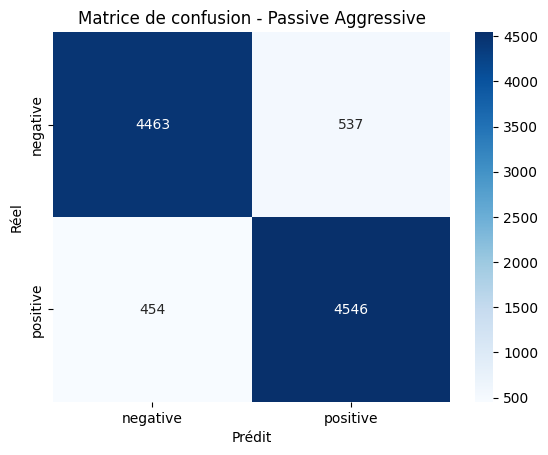

In [10]:
print("=== Rapport de classification ===")
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "positive"],
            yticklabels=["negative", "positive"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Passive Aggressive")
plt.show()